# Call surface recovery


We follow Practitioner's Black Scholes (PBS1, PBS2), Spline-based interpolation, Orthogonal polynomials with $l^1$ minimization, and Black-Scholes methods to recover the Call surface

We use SPX index option trading data from CBOE on Oct 1st 2025

In [ ]:
import pandas as pd
import numpy as np
import pandas_market_calendars as mcal
import matplotlib.pyplot as plt
import cvxpy as cp
import matplotlib.colors as mcolors

from scipy.stats import norm as stats_norm
from scipy.optimize import minimize
from scipy.interpolate import BSpline
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import SmoothBivariateSpline


%matplotlib widget


data_26apr=pd.read_csv("spx_quotedata.csv", skiprows=3)
data_26may=pd.read_csv("spx_quotedata-2.csv", skiprows=3)
data_26jun=pd.read_csv("spx_quotedata-3.csv", skiprows=3)
data_26jul=pd.read_csv("spx_quotedata-4.csv", skiprows=3)
data_26aug=pd.read_csv("spx_quotedata_aug.csv", skiprows=3)
data_26sep=pd.read_csv("spx_quotedata-5.csv", skiprows=3)
data_26oct=pd.read_csv("spx_quotedata-6.csv", skiprows=3)
data_26dec=pd.read_csv("spx_quotedata-7.csv", skiprows=3)
data_27jan=pd.read_csv("spx_quotedata-8.csv", skiprows=3)
data_27jun=pd.read_csv("spx_quotedata-9.csv", skiprows=3)
data_27dec=pd.read_csv("spx_quotedata-10.csv", skiprows=3)

data_all=pd.concat([data_26apr,data_26may,data_26jun,data_26jul,data_26aug,data_26sep, data_26oct, data_26dec,data_27jan, data_27jun, data_27dec], axis=0, ignore_index=True)



S0= 6711.2


data_all["Expiration Calendar"] = (
    pd.to_datetime(data_all["Expiration Date"], format="%a %b %d %Y")
      .dt.strftime("%m-%d-%Y")
)
nyse = mcal.get_calendar("NYSE")
start_date = pd.Timestamp("2025-10-01")

def trading_days_until(expiry):
    schedule = nyse.schedule(start_date=start_date, end_date=expiry)
    return len(mcal.date_range(schedule, frequency="1D"))


#Compute maturities by trading days / 252
data_all["Maturities"] = (data_all["Expiration Calendar"].apply(trading_days_until))/252

#Strikes measured in comparison to S0
data_all["Strikes"] = (data_all["Calls"].astype(str).str[-8:].astype(int)/1000)/S0

#Call price = mid (bid , ask)
data_all["Prices"]=0.5*data_all["Bid"]+0.5*data_all["Ask"]



#Data choice
mask = (
    (data_all["Volume"] >=  20) &
    (data_all["Strikes"] > 0) &
    (data_all["Maturities"] > 0)
)
data_points = data_all[mask].copy()

mask = (
    (data_all["Volume"] >=  50) &
    (data_all["Strikes"] > 1) &
    (data_all["Strikes"] < 1.5) &
    (data_all["Maturities"] > 0.5) &
    (data_all["Maturities"] < 1.8)
)
data_points = data_all[mask].copy()




## PBS 1

We start with the Practitioner's Black Scholes (PBS) which is regressing a quadratic polynomial as a function of $K$ and $T$ to determine coefficients in the model: $$C(K,T) = b_0 + b_1K +b_2 K^2 + b_3 KT + b_4 T.$$

b = [  7772.41626306 -13002.47474001   5343.74159573  -1121.79050749
   1524.32320503]


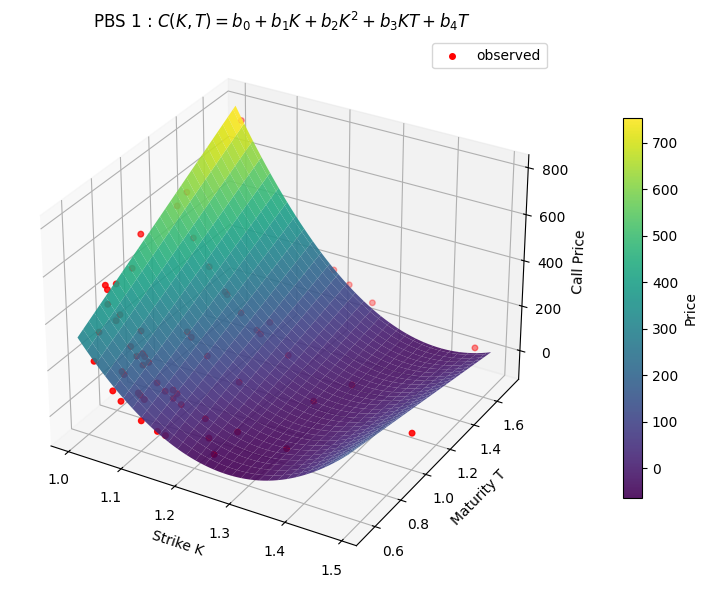

R^2: 0.9706


In [87]:
K = data_points["Strikes"]
T = data_points["Maturities"]  
call_data=data_points['Prices']

# 1) Build design matrix and solve OLS
X = np.column_stack([np.ones_like(K), K, K**2, K*T, T])
b, *_ = np.linalg.lstsq(X, call_data, rcond=None)
print("b =", b)  # [b1, b2, b3, b4, b5]

# 2) Predictor
def call_pbs1_hat(Knew, Tnew):
    return b[0] + b[1]*Knew + b[2]*Knew**2 + b[3]*Knew*Tnew + b[4]*Tnew

# 3) Make a grid to visualize the fitted surface
K_grid = np.linspace(K.min(), K.max(), 60)
T_grid = np.linspace(T.min(), T.max(), 60)
Kg, Tg = np.meshgrid(K_grid, T_grid, indexing="ij")
Zg = call_pbs1_hat(Kg, Tg)

# 4) 3D plot: fitted surface + scatter of observations
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(Kg, Tg, Zg, cmap="viridis", edgecolor="none", alpha=0.9)
ax.scatter(K, T, call_data, s=16, c='r', label="observed")

ax.set_title(r"PBS 1 : $C(K,T)=b_0+b_1K+b_2K^2+b_3KT+b_4T$")
ax.set_xlabel("Strike K")
ax.set_ylabel("Maturity T")
ax.set_zlabel("Call Price")
fig.colorbar(surf, shrink=0.7, pad=0.08, label="Price")
ax.legend()
plt.tight_layout()
plt.show()

# (Optional) R^2 on the training data
call_pbs1_pred = X @ b
R2 = 1 - np.sum((call_data - call_pbs1_pred)**2) / np.sum((call_data - call_data.mean())**2)
print(f"R^2: {R2:.4f}")

## PBS 2
Now, we try PBS2 which is regressing to the surface $$C(K,T) = b_0 + b_1 K + b_2 K^2 +b_3 KT + b_4T + b_5 K^3 + b_6 K^2T + b_7 T^2.$$

b = [ 3.10066857e+04 -7.25502181e+04  5.58949157e+04 -4.11692143e+03
  3.22929271e+03 -1.42036994e+04  1.30550351e+03 -8.71269317e+00]


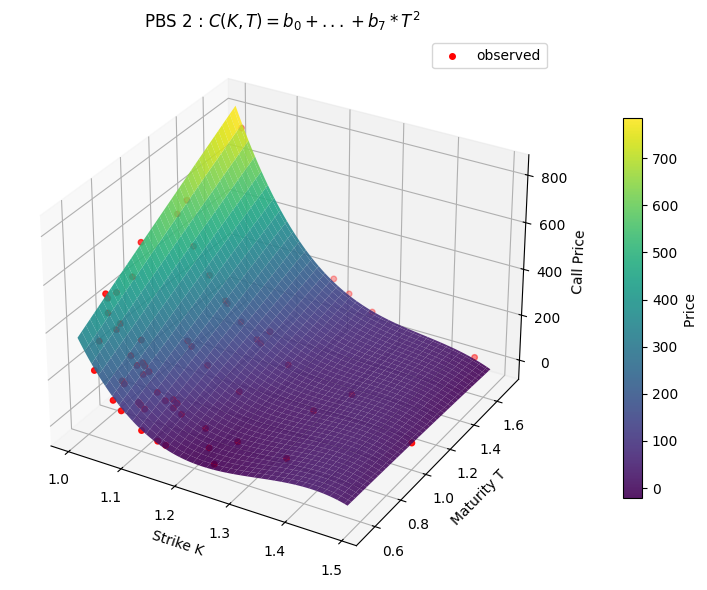

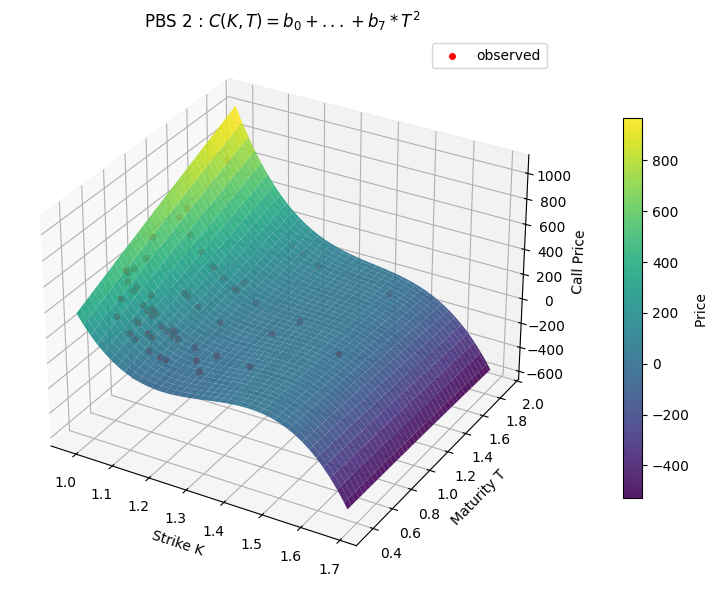

R^2: 0.9969


In [88]:
K = data_points["Strikes"]
T = data_points["Maturities"] 
call_data=data_points['Prices']

# 1) Build design matrix and solve OLS
X = np.column_stack([np.ones_like(K), K, K**2, K*T,T, K**3, K**2*T, T**2, ])
b, *_ = np.linalg.lstsq(X, call_data, rcond=None)
print("b =", b)  # [b0, b1, b2, b3, b4, b5,  b6, b7  ]

# 2) Predictor
def sigma_hat(Knew, Tnew):
    return b[0] + b[1]*Knew + b[2]*Knew**2 + b[3]*Knew*Tnew \
            + b[4]*Tnew + b[5]*Knew**3 + b[6]*Knew**2*Tnew + b[7]*Tnew**2


# 3) Make a grid to visualize the fitted surface
K_grid = np.linspace(K.min(), K.max(), 80)
T_grid = np.linspace(T.min(), T.max(), 80)
Kg, Tg = np.meshgrid(K_grid, T_grid, indexing="ij")
Zg = sigma_hat(Kg, Tg)

# 4) 3D plot: fitted surface + scatter of observations
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(Kg, Tg, Zg, cmap="viridis", edgecolor="none", alpha=0.9)
ax.scatter(K, T, call_data, s=16, c='r', label="observed")

ax.set_title(r"PBS 2 : $C(K,T)=b_0+...+b_7*T^2$")
ax.set_xlabel("Strike K")
ax.set_ylabel("Maturity T")
ax.set_zlabel("Call Price")
fig.colorbar(surf, shrink=0.7, pad=0.08, label="Price ")
ax.legend()
plt.tight_layout()
plt.show()


# 3) Make a grid to visualize the fitted surface
K_grid = np.linspace(K.min()-.02, K.max()+0.2, 80)
T_grid = np.linspace(T.min()-0.2, T.max()+0.2, 80)
Kg, Tg = np.meshgrid(K_grid, T_grid, indexing="ij")
Zg = sigma_hat(Kg, Tg)

# 4) 3D plot: fitted surface + scatter of observations
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(Kg, Tg, Zg, cmap="viridis", edgecolor="none", alpha=0.9)
ax.scatter(K, T, call_data, s=16, c='r', label="observed")

ax.set_title(r"PBS 2 : $C(K,T)=b_0+...+b_7*T^2$")
ax.set_xlabel("Strike K")
ax.set_ylabel("Maturity T")
ax.set_zlabel("Call Price")
fig.colorbar(surf, shrink=0.7, pad=0.08, label="Price ")
ax.legend()
plt.tight_layout()
plt.show()

# (Optional) R^2 on the training data
sigma_pred = X @ b
R2 = 1 - np.sum((call_data - sigma_pred)**2) / np.sum((call_data - call_data.mean())**2)
print(f"R^2: {R2:.4f}")

## Interpolation using B-Spline

Instead of using regression, now we interpolate using splines.

/var/folders/9f/9lklx6h576vc_hk1h6qgvb6w0000gn/T/ipykernel_33803/2608268015.py:9: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  spline = SmoothBivariateSpline(K, T, Z, kx=3, ky=3, s=5.0)


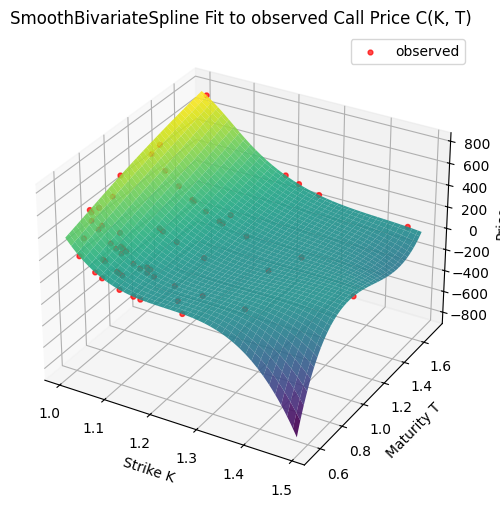

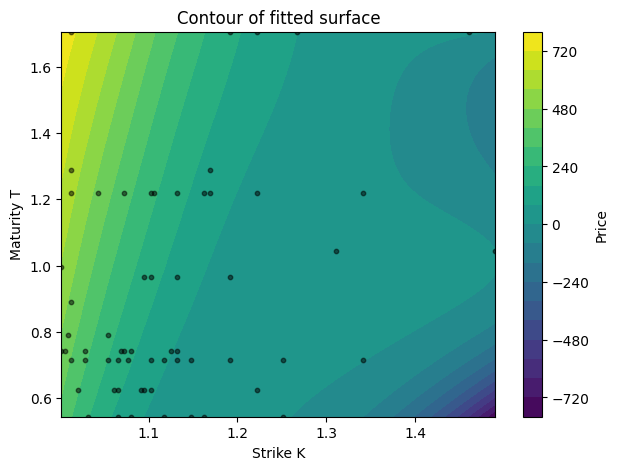

Butterfly violations (analytic d2C/dK2 < 0): 5359


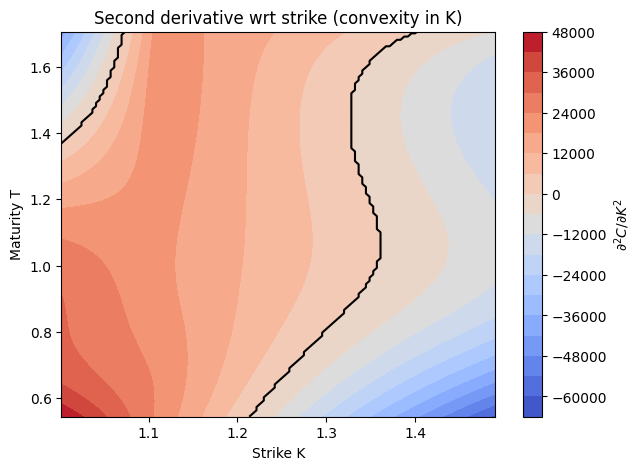

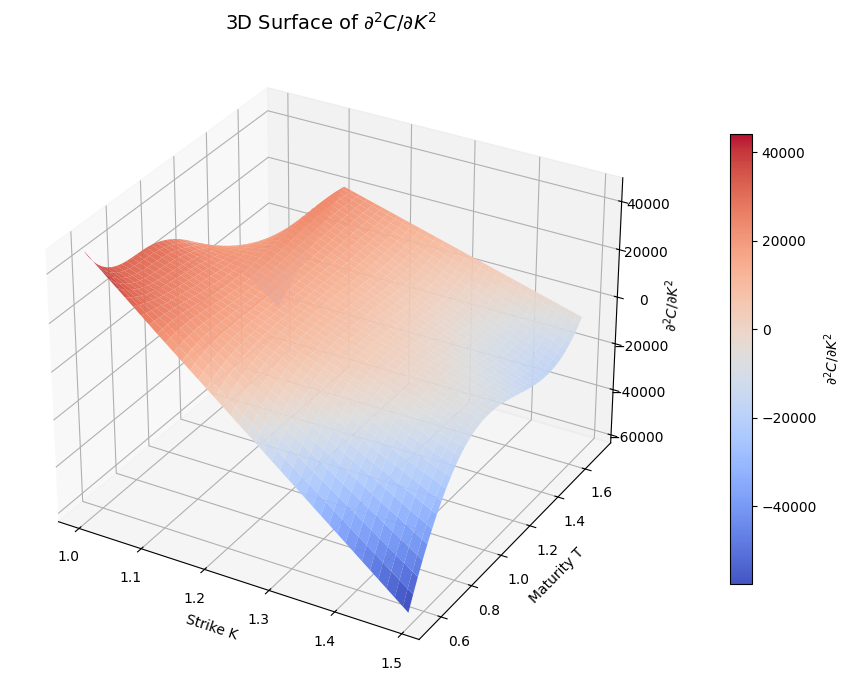

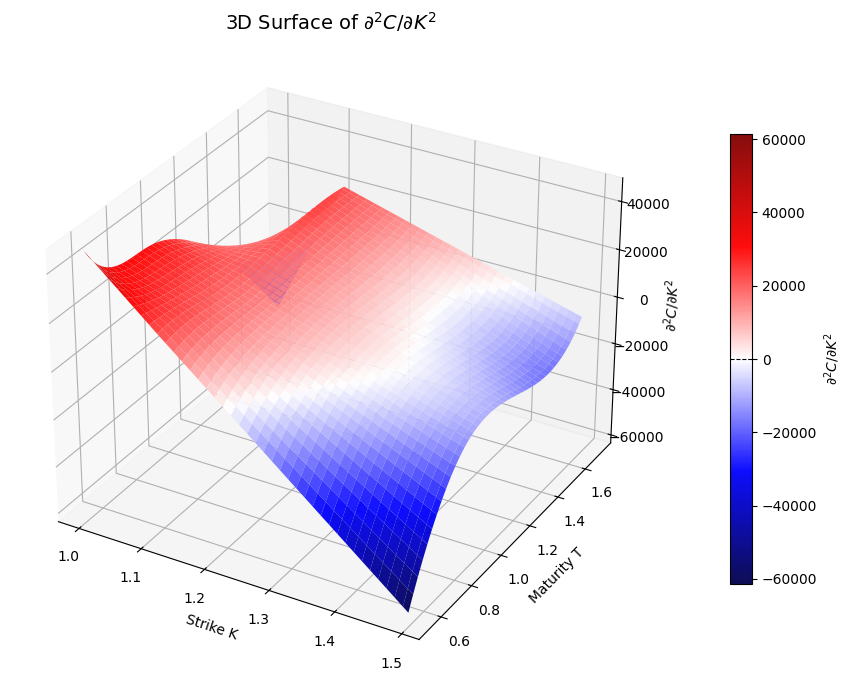

Butterfly violations (finite diff) : 5358


In [89]:

K = data_points["Strikes"]      
T = data_points["Maturities"]       

Z = data_points["Prices"]


# --- 2) Fit scattered-data spline (cubic in each dir) ---
# s is a smoothing parameter; try s=0 for near-interpolation, larger s for smoother fit
spline = SmoothBivariateSpline(K, T, Z, kx=3, ky=3, s=5.0)

# --- 3) Evaluate on a regular grid for plotting ---
K_new = np.linspace(min(K), max(K), 120)
#K_new = np.linspace(1, 1.2, 120)
T_new = np.linspace(min(T), max(T), 120)
#T_new = np.linspace(1, 1.5, 120)
Kg, Tg = np.meshgrid(K_new, T_new, indexing='ij')
Z_fit = spline(K_new, T_new)  # returns 2D array len(K_new) x len(T_new)

# --- 4A) 3D surface plot + scatter of original points ---
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Kg, Tg, Z_fit, cmap='viridis', edgecolor='none', alpha=0.9)
ax.scatter(K, T, Z, s=12, c='r', alpha=0.7, label='observed')
ax.set_title("SmoothBivariateSpline Fit to observed Call Price C(K, T)")
ax.set_xlabel("Strike K"); ax.set_ylabel("Maturity T"); ax.set_zlabel("Price")
ax.legend()
plt.show()

# --- 4B) Contour plot (useful for surfaces like IV) ---
plt.figure(figsize=(7,5))
cs = plt.contourf(Kg, Tg, Z_fit, levels=20, cmap='viridis')
plt.scatter(K, T, s=10, c='k', alpha=0.5)
plt.colorbar(cs, label="Price")
plt.title("Contour of fitted surface")
plt.xlabel("Strike K"); plt.ylabel("Maturity T")
plt.show()



# --- A) Use the spline's analytic partial derivatives ---
# SmoothBivariateSpline / BivariateSpline exposes ev(x,y, dx, dy)
d2C_dK2 = spline.ev(Kg.ravel(), Tg.ravel(), dx=2, dy=0).reshape(Z_fit.shape)

tol = 1e-8  # numerical tolerance
viol_mask = d2C_dK2 < -tol
print("Butterfly violations (analytic d2C/dK2 < 0):", np.count_nonzero(viol_mask))

# visualize where convexity breaks
plt.figure(figsize=(7,5))
plt.contourf(Kg, Tg, d2C_dK2, levels=20, cmap='coolwarm')
plt.colorbar(label=r"$\partial^2 C/\partial K^2$")
plt.contour(Kg, Tg, viol_mask, levels=[0.5], colors="k")  # outline violations
plt.title("Second derivative wrt strike (convexity in K)")
plt.xlabel("Strike K"); plt.ylabel("Maturity T")
plt.show()




# ---------- 4) 3D plot of the second derivative ----------
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(Kg, Tg, d2C_dK2, cmap="coolwarm", edgecolor="none", alpha=0.95)

ax.set_title(r"3D Surface of $\partial^2 C / \partial K^2$", fontsize=14)
ax.set_xlabel("Strike K")
ax.set_ylabel("Maturity T")
ax.set_zlabel(r"$\partial^2 C / \partial K^2$")
fig.colorbar(surf, shrink=0.7, pad=0.08, label=r"$\partial^2 C / \partial K^2$")
plt.tight_layout()
plt.show()







import matplotlib.colors as mcolors

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

# Find global limits for symmetric color scaling around zero
vmax = np.max(np.abs(d2C_dK2))
vmin = -vmax

# Use a diverging colormap such as 'seismic', 'RdBu_r', or 'coolwarm'
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

surf = ax.plot_surface(
    Kg, Tg, d2C_dK2,
    cmap="seismic",        # you can try 'RdBu_r', 'PuOr', 'coolwarm', etc.
    norm=norm,
    linewidth=0,
    antialiased=True,
    alpha=0.95
)

ax.set_title(r"3D Surface of $\partial^2 C / \partial K^2$", fontsize=14)
ax.set_xlabel("Strike K")
ax.set_ylabel("Maturity T")
ax.set_zlabel(r"$\partial^2 C / \partial K^2$")

# Colorbar with clear zero-centered range
cbar = fig.colorbar(surf, shrink=0.7, pad=0.08)
cbar.set_label(r"$\partial^2 C / \partial K^2$")
cbar.ax.axhline(0, color='k', linewidth=0.8, linestyle='--')  # mark zero level

plt.tight_layout()
plt.show()








# --- B) Finite-difference convexity check along K-axis ---
# First derivative wrt K (axis=0), then second derivative
dC_dK  = np.gradient(Z_fit, K_new, axis=0, edge_order=2)
d2_fd  = np.gradient(dC_dK, K_new, axis=0, edge_order=2)

viol_mask_fd = d2_fd < -1e-8
print("Butterfly violations (finite diff) :", np.count_nonzero(viol_mask_fd))






## Constrained B-Spline

We constrain our surface to the following no-arbitrage conditions.

First, we impose absence of butterfly-spread arbitrage. (Convexity in $K$)
$$\frac{\partial^2 C}{\partial K^2}\geq 0$$
Second, we impose absence of calendar-spread arbitrage. (Monotonicity in $T$)
$$\frac{\partial C}{\partial T}\geq 0$$

status: user_limit objective: 109.04736780682072
115    1.031857
117    1.043033
118    1.046758
122    1.065383
124    1.072833
         ...   
955    1.519847
956    1.549648
971    0.998331
974    1.072833
978    1.162236
Name: Strikes, Length: 116, dtype: float64 115    0.543651
117    0.543651
118    0.543651
122    0.543651
124    0.543651
         ...   
955    1.706349
956    1.706349
971    2.210317
974    2.210317
978    2.210317
Name: Maturities, Length: 116, dtype: float64


/Users/hongkijung/.pyenv/versions/3.11.9/lib/python3.11/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


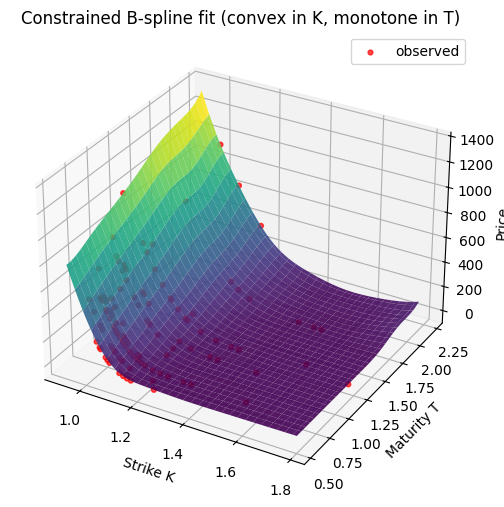

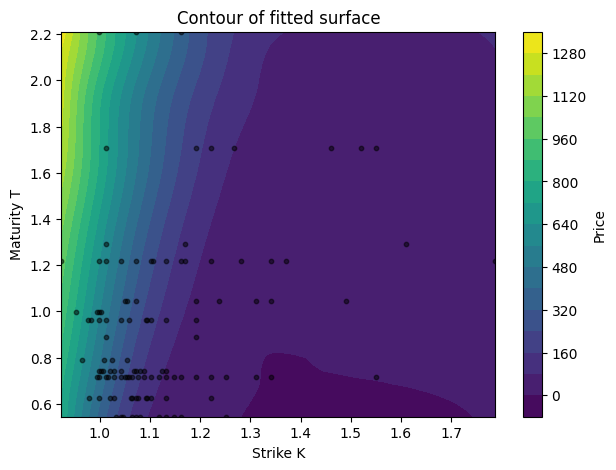

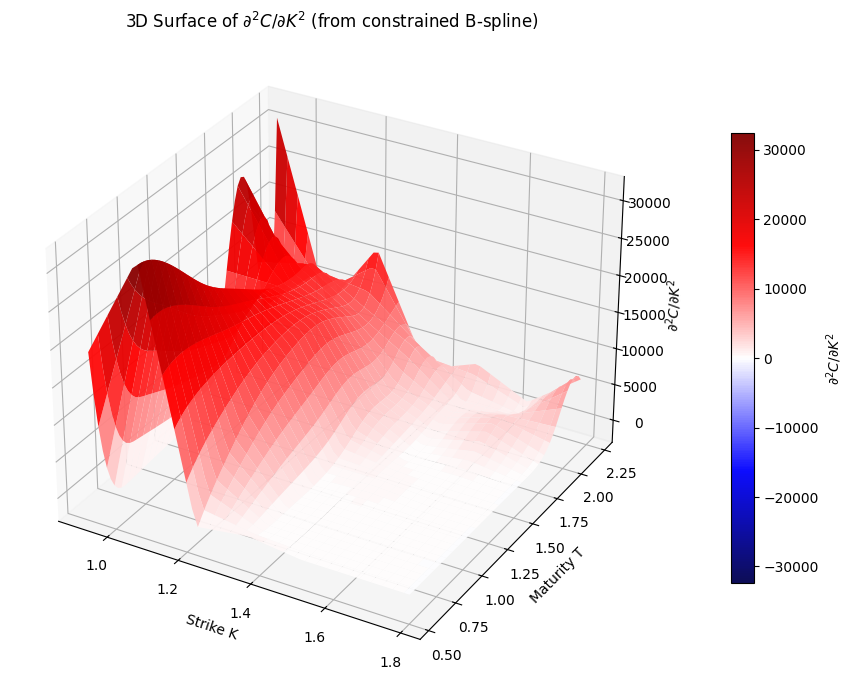

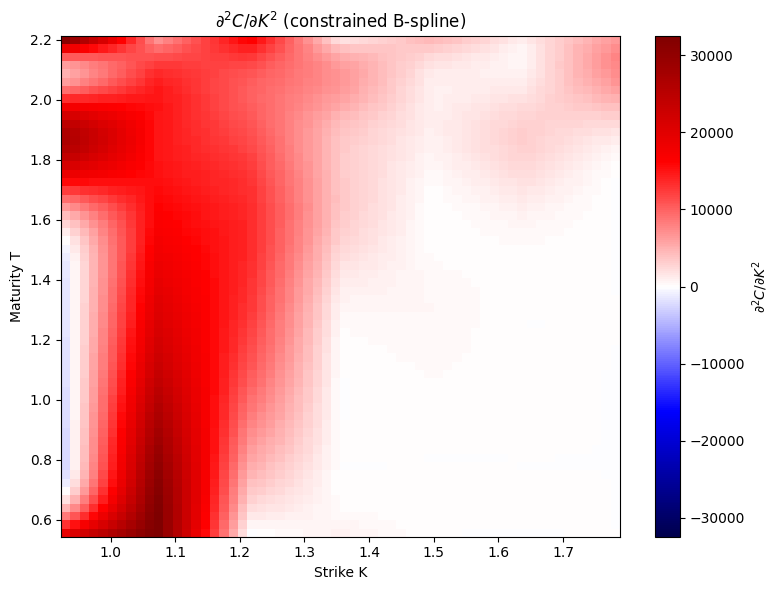

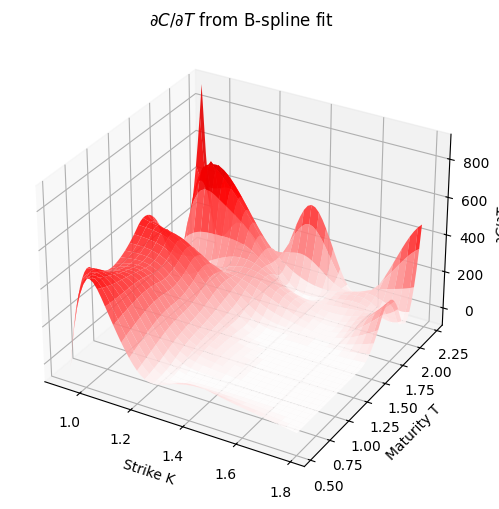

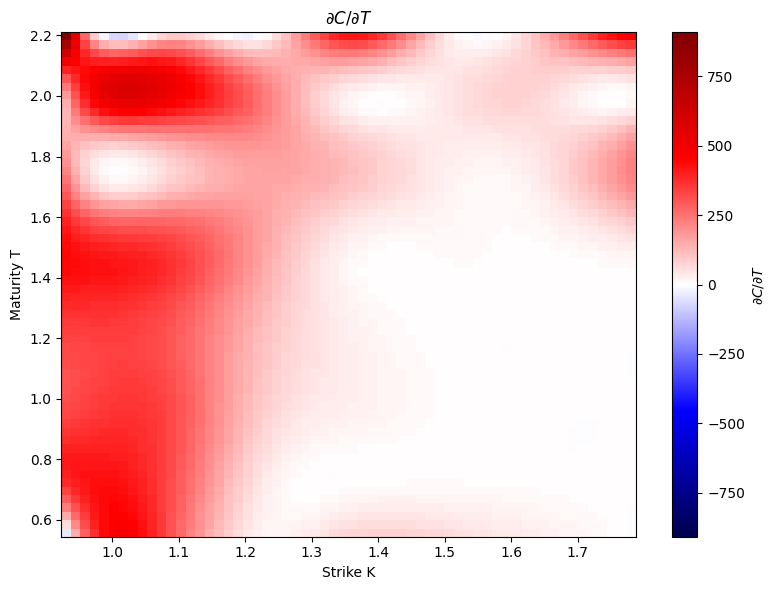

In [90]:
# ---------- helpers ----------
def clamped_uniform_knots(xmin, xmax, n_internal, degree):
    internals = np.linspace(xmin, xmax, n_internal+2)[1:-1]  # exclude endpoints
    return np.r_[ [xmin]*(degree+1), internals, [xmax]*(degree+1) ]

def bspline_basis_matrix(x, knots, degree):
    x = np.asarray(x, dtype=float)
    n_basis = len(knots) - degree - 1
    B = np.zeros((x.size, n_basis))
    for i in range(n_basis):
        coeff = np.zeros(n_basis); coeff[i] = 1.0
        B[:, i] = BSpline(knots, coeff, degree)(x)
    return B

def first_diff(n):
    D = np.zeros((n-1, n))
    for i in range(n-1):
        D[i,i] = -1.0; D[i,i+1] = 1.0
    return D

def second_diff(n):
    D2 = np.zeros((n-2, n))
    for i in range(n-2):
        D2[i,i] = 1.0; D2[i,i+1] = -2.0; D2[i,i+2] = 1.0
    return D2


def bspline_basis_first_matrix(x, knots, degree):
    x = np.asarray(x, float)
    n_basis = len(knots) - degree - 1
    Bp = np.zeros((x.size, n_basis))
    for i in range(n_basis):
        coeff = np.zeros(n_basis); coeff[i] = 1.0
        spl = BSpline(knots, coeff, degree)
        Bp[:, i] = spl.derivative(1)(x)
    return Bp

def bspline_basis_second_matrix(x, knots, degree):
    x = np.asarray(x, float)
    n_basis = len(knots) - degree - 1
    Bpp = np.zeros((x.size, n_basis))
    for i in range(n_basis):
        coeff = np.zeros(n_basis); coeff[i] = 1.0
        spl = BSpline(knots, coeff, degree)
        Bpp[:, i] = spl.derivative(2)(x)
    return Bpp



mask = (
    (data_all["Volume"] >=  20) &
    (data_all["Strikes"] > 0) &
    (data_all["Strikes"] < 2) &
    (data_all["Maturities"] > 0) &
    (data_all["Maturities"] < 3)
)
data_points = data_all[mask].copy()
K=data_points['Strikes']
T=data_points['Maturities']







K = data_points["Strikes"]        # strikes (scattered)
N = len(K)
T = data_points["Maturities"]         # maturities (scattered)
Z = data_points["Prices"]             # noisy obs
w = np.ones_like(Z)                   # (optional) weights



r = 0.00  # ~5% current U.S. short rate
D = np.exp(-r * T)
D = np.asarray(D, dtype=float)



# ---------- spline bases ----------
degK, degT = 3, 3
knots_K = clamped_uniform_knots(K.min(), K.max(), n_internal=5, degree=degK)
knots_T = clamped_uniform_knots(T.min(), T.max(), n_internal=5, degree=degT)
B_K = bspline_basis_matrix(K, knots_K, degK)     # (N, nBK)
B_T = bspline_basis_matrix(T, knots_T, degT)     # (N, nBT)
nBK, nBT = B_K.shape[1], B_T.shape[1]

# Design matrix for tensor product: Z ≈ Σ_{ij} c_{ij} B_i(K) B_j(T)
# Row-wise build A with Khatri–Rao product (rowwise Kronecker):
A = np.einsum('pi,pj->pij', B_K, B_T).reshape(N, nBK*nBT)


A_discounted=A*D[:, None]

# ---------- constraints (linear in coeffs c = vec(C)) ----------
D1_T = first_diff(nBT)      # monotonicity in T  (first diff >= 0)
D2_K = second_diff(nBK)     # convexity in K     (second diff >= 0)
I_T = np.eye(nBT); I_K = np.eye(nBK)
C_mono_T   = np.kron(D1_T, I_K)   # ( (nBT-1)*nBK , nBK*nBT )
C_convex_K = np.kron(I_T, D2_K)   # ( (nBK-2)*nBT , nBK*nBT )





# ---------- CVXPy problem ----------
c = cp.Variable(nBK*nBT)
W = np.diag(w)  # point weights if you want weighted LS
# smoothing penalties (Tikhonov): encourage smooth coeffs along K and T
#rhoK, rhoT = 1e-2, 1e-2
rhoK, rhoT = 0, 0
pen_K = np.kron(I_T, D2_K) @ c
pen_T = np.kron(D1_T, I_K) @ c

obj = cp.Minimize(cp.sum_squares(W @ (A_discounted @ c - Z))
                  + rhoK*cp.sum_squares(pen_K)
                  + rhoT*cp.sum_squares(pen_T))

#constraints = [
    #C_convex_K @ c >= 0,   # convex in K
    #C_mono_T   @ c >= 0,   # nondecreasing in T
    ## Optionally: A@c >= 0 to keep prices nonnegative at observed points
#]

# Evaluation grids for constraints (denser grid => stronger guarantee)
Kc = np.linspace(K.min(), K.max(), 80)   # convexity check along K
Tc = np.linspace(T.min(), T.max(), 80)   # monotonicity check along T

BK_c   = bspline_basis_matrix(Kc, knots_K, degK)       # (nKc, nBK)
BppK_c = bspline_basis_second_matrix(Kc, knots_K, degK) # (nKc, nBK)
BpT_c  = bspline_basis_first_matrix(Tc, knots_T, degT)  # (nTc, nBT)
BT_c = bspline_basis_matrix(Tc, knots_T, degT)

# Build linear operators for ALL (Kc,Tc) pairs given c = vec(C) with T-fast order
H_convex_K = np.kron(np.eye(nBT), BppK_c)   # shape (nKc*nBT, nBK*nBT)




#--------------------Check!



H_mono_T   = np.kron(BpT_c, BK_c)           # shape (nTc*nBK, nBK*nBT)
#H_mono_T   = np.kron(BpT_c, np.eye(nBK))           # shape (nTc*nBK, nBK*nBT)


# Optional small slack to tolerate numerical noise
eps_conv = 1e-9
eps_mono = 1e-9

constraints = [
    H_convex_K @ c >= 0, #-eps_conv,   # ∂²C/∂K² ≥ 0
    #H_mono_T   @ c >= 0 #-eps_mono,   # ∂C/∂T ≥ 0  (for each fixed K)
]


#-------------------- Constraints using finite difference


nKc, nTc = BK_c.shape[0], BT_c.shape[0]

# Map coeffs c -> vec(V(Kc,Tc)) with T-fast ordering (last index T)
# vec(V) = kron(BT_c, BK_c) @ c
E = np.kron(BT_c, BK_c)  

D_T_grid  = first_diff(nTc)     # (nTc-1, nTc)
D2_K_grid = second_diff(nKc)    # (nKc-2, nKc)

# Finite-difference constraints on vec(V) = E @ c
# Monotonicity in T for each K: block-diag D_T over K (T-fast ordering)
H_fd_T = np.kron(np.eye(nKc), D_T_grid) @ E          # shape: ((nKc*(nTc-1)) , nBK*nBT)

# Convexity in K for each T: block-diag D2_K over T
H_fd_K = np.kron(D2_K_grid, np.eye(nTc)) @ E         # shape: (((nKc-2)*nTc) , nBK*nBT)

# Optional tiny slack to absorb numeric jitter
eps_T, eps_K = 1e-10, 1e-10

# ---------- Use these instead of derivative-basis constraints ----------
constraints = [
    H_fd_K @ c >= -eps_K,    # ∆²_K C >= 0    (convex in K)
    H_fd_T @ c >= -eps_T,    # ∆_T  C >= 0    (nondecreasing in T)
]




prob = cp.Problem(obj, constraints)
_ = prob.solve()  # choose solver='OSQP' or 'ECOS' if desired

print("status:", prob.status, "objective:", prob.value)




# ---------- evaluate on a grid ----------


print(K, T)

K_new = np.linspace(K.min(), K.max(), 60)
T_new = np.linspace(T.min(), T.max(), 60)
BK_new = bspline_basis_matrix(K_new, knots_K, degK)
BT_new = bspline_basis_matrix(T_new, knots_T, degT)

Cmat = c.value.reshape(nBK, nBT)
Z_fit = BK_new @ Cmat @ BT_new.T   # (60,60)



#---------Plot the second partial derivative in K



# --- 3) Evaluate on a regular grid for plotting ---

K_new = np.linspace(K.min(), K.max(), 60)
T_new = np.linspace(T.min(), T.max(), 60)

Kg, Tg = np.meshgrid(K_new, T_new, indexing='ij')
#Z_fit = spline(K_new, T_new)  # returns 2D array len(K_new) x len(T_new)
Z_fit = BK_new @ Cmat @ BT_new.T   # (60,60)

# --- 4A) 3D surface plot + scatter of original points ---
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Kg, Tg, Z_fit, cmap='viridis', edgecolor='none', alpha=0.9)
ax.scatter(K, T, Z, s=12, c='r', alpha=0.7, label='observed')
ax.set_title("Constrained B-spline fit (convex in K, monotone in T)")
ax.set_xlabel("Strike K"); ax.set_ylabel("Maturity T"); ax.set_zlabel("Price")
ax.legend()
plt.show()

# --- 4B) Contour plot (useful for surfaces like IV) ---
plt.figure(figsize=(7,5))
cs = plt.contourf(Kg, Tg, Z_fit, levels=20, cmap='viridis')
plt.scatter(K, T, s=10, c='k', alpha=0.5)
plt.colorbar(cs, label="Price")
plt.title("Contour of fitted surface")
plt.xlabel("Strike K"); plt.ylabel("Maturity T")
plt.show()





# ---- Compute ∂²C/∂K² from the SAME constrained B-spline surface ----
BKpp_new = bspline_basis_second_matrix(K_new, knots_K, degK)  # (len(K_new), nBK)
d2C_dK2  = BKpp_new @ Cmat @ BT_new.T                         # (len(K_new), len(T_new))

# ---- 3D surface of ∂²C/∂K² (zero-centered diverging colors) ----
import matplotlib.colors as mcolors
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

Kg, Tg = np.meshgrid(K_new, T_new, indexing='ij')
vmax = np.max(np.abs(d2C_dK2)); vmin = -vmax
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

surf = ax.plot_surface(Kg, Tg, d2C_dK2, cmap="seismic", norm=norm,
                       linewidth=0, antialiased=True, alpha=0.95)
ax.set_title(r"3D Surface of $\partial^2 C / \partial K^2$ (from constrained B-spline)")
ax.set_xlabel("Strike K"); ax.set_ylabel("Maturity T"); ax.set_zlabel(r"$\partial^2 C / \partial K^2$")
cbar = fig.colorbar(surf, shrink=0.7, pad=0.08)
cbar.set_label(r"$\partial^2 C / \partial K^2$")
plt.tight_layout(); plt.show()

# ---- Heatmap (aligned with the first graph’s grid) ----


plt.figure(figsize=(8,6))

# Transpose so K runs on x-axis and T on y-axis (same as your 3D mesh)
im = plt.imshow(
    d2C_dK2.T,                  # transpose fixes the flip
    origin="lower",
    extent=[K_new.min(), K_new.max(), T_new.min(), T_new.max()],
    aspect="auto",
    cmap="seismic",
    norm=norm
)

plt.colorbar(im, label=r"$\partial^2 C / \partial K^2$")
plt.title(r"$\partial^2 C / \partial K^2$ (constrained B-spline)")
plt.xlabel("Strike K")
plt.ylabel("Maturity T")
plt.tight_layout()
plt.show()




#----------- Plot the first derivative in T


# Evaluate basis and derivative matrices on the plotting grid
BK_new  = bspline_basis_matrix(K_new, knots_K, degK)        # already have this
BT_new  = bspline_basis_matrix(T_new, knots_T, degT)        # already have this
BTp_new = bspline_basis_first_matrix(T_new, knots_T, degT)  # first derivative in T

# Coefficient matrix from the solver
Cmat = c.value.reshape(nBK, nBT)

# First derivative wrt T on the (K_new, T_new) grid
dC_dT = BK_new @ Cmat @ BTp_new.T     # shape (len(K_new), len(T_new))

Kg, Tg = np.meshgrid(K_new, T_new, indexing="ij")




import matplotlib.colors as mcolors

vmax = np.max(np.abs(dC_dT))
norm = mcolors.TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)

# 3D surface
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(Kg, Tg, dC_dT, cmap="seismic", norm=norm,
                edgecolor="none", alpha=0.9)
ax.set_title(r"$\partial C / \partial T$ from B-spline fit")
ax.set_xlabel("Strike K")
ax.set_ylabel("Maturity T")
ax.set_zlabel(r"$\partial C / \partial T$")
plt.show()

# Heatmap
plt.figure(figsize=(8, 6))
im = plt.imshow(
    dC_dT.T,
    origin="lower",
    extent=[K_new.min(), K_new.max(), T_new.min(), T_new.max()],
    aspect="auto",
    cmap="seismic",
    norm=norm
)
plt.colorbar(im, label=r"$\partial C / \partial T$")
plt.title(r"$\partial C / \partial T$")
plt.xlabel("Strike K")
plt.ylabel("Maturity T")
plt.tight_layout()
plt.show()

## Blaack Scholes Call Price

Now we use Black-Scholes using parameter calibration on $\sigma, r$ and least squares method.

/var/folders/9f/9lklx6h576vc_hk1h6qgvb6w0000gn/T/ipykernel_33803/762588996.py:60: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result = minimize(


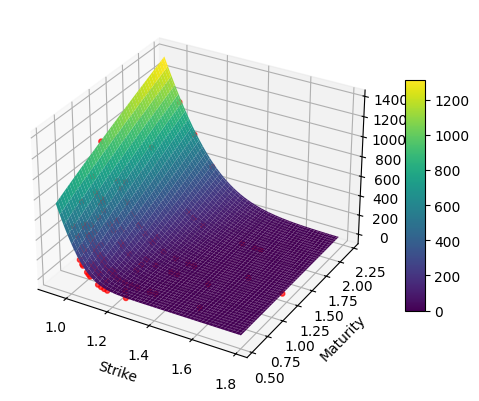

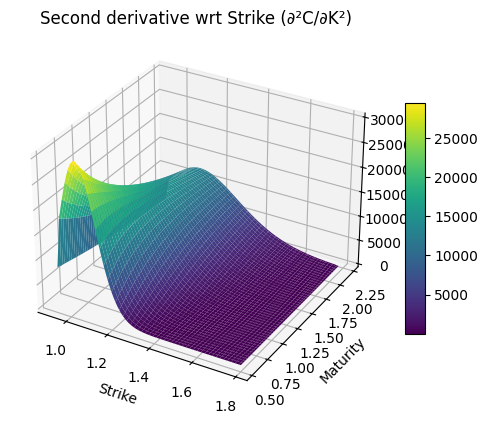

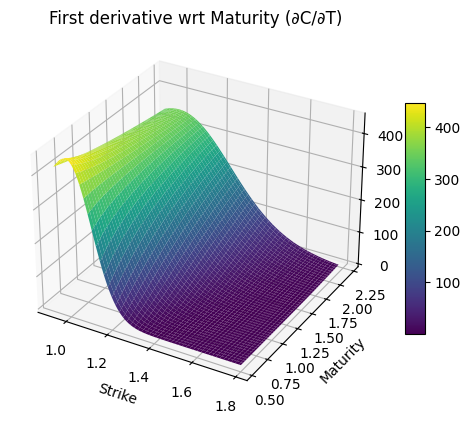

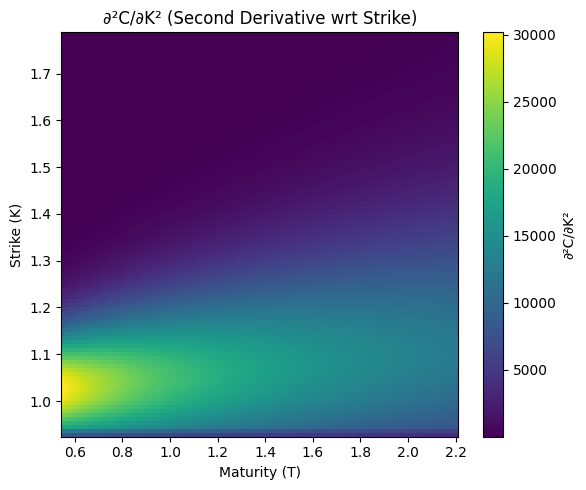

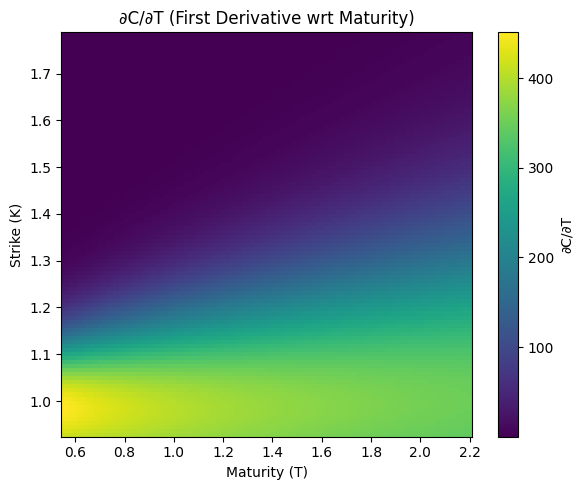

In [91]:
from itertools import product
##Black-Scholes Functions
def bs_call(S0, K, sigma, t, r):
    '''
    Black-Scholes Call Option formula
    
    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate
    
    
    Return:
    Black-Scholes value of call option (float)
    '''
    
    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))
    
    d2 = d1 - sigma*np.sqrt(t)
    
    
    call_value = S0*stats_norm.cdf(d1) - K*np.exp(-r*t)*stats_norm.cdf(d2)
    
    
    return call_value



def objective_bs(params, data):
    sigma, r = params
    
    
    error = 0
    for _, row in data.iterrows():
        model_price = bs_call(
            S0=S0,
            K=row['Strikes']*S0,
            sigma=sigma,
            t=row['Maturities'],
            r=r
        )
        market_price = row['Prices']
        error += (model_price - market_price) ** 2
        
    return error / len(data)




#BS model
#need to create a reasonable first guess and set bounds for our model calibration

initial_guess = [.4**2, 0.05]  # theta ,r 
bounds = [(.1**2, .9**2), (.02, .16)] 



result = minimize(
    objective_bs,
    initial_guess,
    args=(data_points,),
    bounds=bounds,
    method='L-BFGS-B',
    options={
        'disp': True,
        'maxiter': 20,       
        'ftol': 1e-4,         
        'gtol': 1e-4          
    }
)


calibrated_params_bs = result.x

sigma, r =calibrated_params_bs
sigma, r



mask = (
    (data_all["Volume"] >=  20) &
    (data_all["Strikes"] > 0) &
    (data_all["Strikes"] < 2) &
    (data_all["Maturities"] > 0) &
    (data_all["Maturities"] < 3)
)
data_points = data_all[mask].copy()
K=data_points['Strikes']
T=data_points['Maturities']


# assume strikes and maturities are 1-D arrays/lists

strikes = np.linspace(np.min(np.unique(K)), np.max(np.unique(K)), 100)
maturities = np.linspace(np.min(np.unique(T)), np.max(np.unique(T)), 100) 

grid_prices_bs = np.array([
    bs_call(S0, K*S0, sigma, T,r)
    for K, T in product(strikes, maturities)
])



# grid_prices_bs came from product(strikes, maturities)
Z = grid_prices_bs.reshape(len(strikes), len(maturities))  # price grid
K_grid, T_grid = np.meshgrid(strikes, maturities, indexing="ij")  # match reshape order

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(K_grid, T_grid, Z, cmap="viridis", edgecolor="none")

ax.set_xlabel("Strike")
ax.set_ylabel("Maturity")
ax.set_zlabel("BS Price")
fig.colorbar(surf, shrink=0.6, aspect=12)






ax.scatter(data_points['Strikes'], data_points['Maturities'], data_points['Prices'], s=12, c='r', alpha=0.7, label='observed')






plt.show()





# --- Derivatives ---
# grid spacings (regular since you used linspace)
dK = strikes[1] - strikes[0]
dT = maturities[1] - maturities[0]

# First derivatives along K (axis=0) and T (axis=1)
dZ_dK, dZ_dT = np.gradient(Z, dK, dT)

# Second derivative w.r.t. K: take the K-derivative of dZ_dK
d2Z_dK2, _ = np.gradient(dZ_dK, dK, dT)

# --- Plots ---

# 3D surface: second derivative w.r.t. K
fig2 = plt.figure(figsize=(6, 5))
ax2 = fig2.add_subplot(111, projection="3d")
surf2 = ax2.plot_surface(K_grid, T_grid, d2Z_dK2, cmap="viridis", edgecolor="none")
ax2.set_xlabel("Strike")
ax2.set_ylabel("Maturity")
ax2.set_zlabel("∂²C/∂K²")
fig2.colorbar(surf2, shrink=0.6, aspect=12)
plt.title("Second derivative wrt Strike (∂²C/∂K²)")

# 3D surface: first derivative w.r.t. T
fig3 = plt.figure(figsize=(6, 5))
ax3 = fig3.add_subplot(111, projection="3d")
surf3 = ax3.plot_surface(K_grid, T_grid, dZ_dT, cmap="viridis", edgecolor="none")
ax3.set_xlabel("Strike")
ax3.set_ylabel("Maturity")
ax3.set_zlabel("∂C/∂T")
fig3.colorbar(surf3, shrink=0.6, aspect=12)
plt.title("First derivative wrt Maturity (∂C/∂T)")

plt.show()



# assuming you already have:
# strikes, maturities, dZ_dT, d2Z_dK2

# --- Heatmap 1: ∂²C/∂K² (second derivative wrt Strike) ---
plt.figure(figsize=(6, 5))
plt.imshow(
    d2Z_dK2,
    extent=[maturities.min(), maturities.max(), strikes.min(), strikes.max()],
    origin='lower',
    aspect='auto',
    cmap='viridis'
)
plt.colorbar(label='∂²C/∂K²')
plt.xlabel('Maturity (T)')
plt.ylabel('Strike (K)')
plt.title('∂²C/∂K² (Second Derivative wrt Strike)')
plt.tight_layout()
plt.show()


# --- Heatmap 2: ∂C/∂T (first derivative wrt Maturity) ---
plt.figure(figsize=(6, 5))
plt.imshow(
    dZ_dT,
    extent=[maturities.min(), maturities.max(), strikes.min(), strikes.max()],
    origin='lower',
    aspect='auto',
    cmap='viridis'
)
plt.colorbar(label='∂C/∂T')
plt.xlabel('Maturity (T)')
plt.ylabel('Strike (K)')
plt.title('∂C/∂T (First Derivative wrt Maturity)')
plt.tight_layout()
plt.show()
